In [3]:
# !pip install gpflow

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

In [6]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [7]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

    return X, Y

In [8]:
X, Y = data = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

In [9]:
X.shape, Y.shape

((100, 1), (100, 3))

In [10]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

In [11]:
# create multi-output kernel
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

2022-07-25 15:16:25.390235: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-25 15:16:25.390263: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (danh-ubuntu): /proc/driver/nvidia/version does not exist
2022-07-25 15:16:25.390984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-5....
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1., 0., 0...."


In [13]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          424     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26251D+03    |proj g|=  1.79322D+03

At iterate    1    f=  1.42381D+03    |proj g|=  5.94444D+02

At iterate    2    f=  8.84935D+02    |proj g|=  3.56771D+02

At iterate    3    f=  5.15138D+02    |proj g|=  5.86730D+01

At iterate    4    f=  4.91599D+02    |proj g|=  4.57648D+01

At iterate    5    f=  4.83878D+02    |proj g|=  4.25475D+01

At iterate    6    f=  4.55434D+02    |proj g|=  2.73693D+01

At iterate    7    f=  4.20808D+02    |proj g|=  5.49701D+01

At iterate    8    f=  4.04327D+02    |proj g|=  7.51807D+01

At iterate    9    f=  3.80875D+02    |proj g|=  5.05081D+01

At iterate   10    f=  3.60975D+02    |proj g|=  4.18280D+01

At iterate   11    f=  3.56982D+02    |proj g|=  2.16764D+01

At iterate   12    f=  3.46620D+02    |proj g|=  4.81397D+01

At iterate   13    f=  3.4

 This problem is unconstrained.



At iterate  225    f=  4.91104D+01    |proj g|=  1.47920D+01

At iterate  226    f=  4.90637D+01    |proj g|=  1.00761D+01

At iterate  227    f=  4.90136D+01    |proj g|=  6.79849D+00

At iterate  228    f=  4.89773D+01    |proj g|=  1.72625D+01

At iterate  229    f=  4.89188D+01    |proj g|=  1.26760D+01

At iterate  230    f=  4.88585D+01    |proj g|=  1.49808D+01

At iterate  231    f=  4.87545D+01    |proj g|=  1.48287D+01

At iterate  232    f=  4.87362D+01    |proj g|=  1.13923D+01

At iterate  233    f=  4.87036D+01    |proj g|=  5.97346D+00

At iterate  234    f=  4.86715D+01    |proj g|=  7.94049D+00

At iterate  235    f=  4.86252D+01    |proj g|=  1.01263D+01

At iterate  236    f=  4.86018D+01    |proj g|=  2.64895D+01

At iterate  237    f=  4.85555D+01    |proj g|=  6.48395D+00

At iterate  238    f=  4.85363D+01    |proj g|=  3.66973D+00

At iterate  239    f=  4.85186D+01    |proj g|=  5.93240D+00

At iterate  240    f=  4.84861D+01    |proj g|=  1.13855D+01

At iter

In [14]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9268508032298146
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.7981538269432151
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.21495327034503
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.039663056395729854
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-4.83936541...
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[-0.90053862, 0.69818418, -1.47329934..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1.71024058e-02, 0.00000000e+00, 0.00000000e+00..."


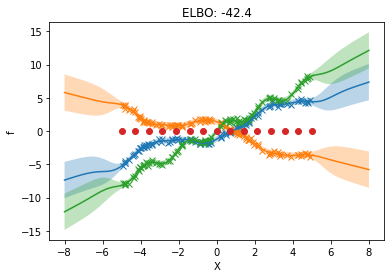

In [15]:
# Plot predictions and observations
plot_model(m)

In [16]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

name,class,transform,prior,trainable,shape,dtype,value
SharedIndependent.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.926851
SharedIndependent.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.798154
SharedIndependent.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.21495


<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7981538269432151>

### 2. Separate independent MOK and shared independent inducing variables

In [17]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [18]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [19]:
optimize_model_with_scipy(m)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_fileqyfx1osl.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_fileqyfx1osl.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          430     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.

 This problem is unconstrained.



At iterate  149    f=  6.13264D+01    |proj g|=  6.43918D+01

At iterate  150    f=  6.09436D+01    |proj g|=  2.36559D+01

At iterate  151    f=  6.06185D+01    |proj g|=  3.07207D+01

At iterate  152    f=  5.98195D+01    |proj g|=  4.86867D+01

At iterate  153    f=  5.95511D+01    |proj g|=  6.12982D+01

At iterate  154    f=  5.91659D+01    |proj g|=  3.35010D+01

At iterate  155    f=  5.88707D+01    |proj g|=  3.95893D+01

At iterate  156    f=  5.87268D+01    |proj g|=  3.00090D+01

At iterate  157    f=  5.85939D+01    |proj g|=  2.37085D+01

At iterate  158    f=  5.81845D+01    |proj g|=  1.52398D+01

At iterate  159    f=  5.79954D+01    |proj g|=  1.84209D+01

At iterate  160    f=  5.73551D+01    |proj g|=  2.40326D+01

At iterate  161    f=  5.70313D+01    |proj g|=  6.61509D+01

At iterate  162    f=  5.65465D+01    |proj g|=  2.45353D+01

At iterate  163    f=  5.63116D+01    |proj g|=  1.07780D+01

At iterate  164    f=  5.62149D+01    |proj g|=  1.96628D+01

At iter

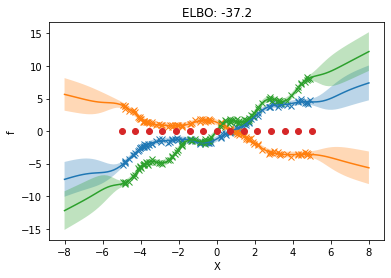

In [20]:
plot_model(m)

In [21]:
[k.kernels[0].lengthscales for k in m.kernel.kernels]

[<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.93467977167029>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.9697257537023442>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7492052765122805>]

### 3. Separate independent kernel and separate independent inducing variables

In [22]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [23]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [24]:
optimize_model_with_scipy(m)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          460     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26251D+03    |proj g|=  1.79322D+03

At iterate    1    f=  1.42015D+03    |proj g|=  6.05642D+02

At iterate    2    f=  8.19726D+02    |proj g|=  3.33030D+02

At iterate    3    f=  5.14305D+02    |proj g|=  4.54513D+01

At iterate    4    f=  4.98859D+02    |proj g|=  2.70375D+01

At iterate    5    f=  4.92883D+02    |proj g|=  1.65439D+01

At iterate    6    f=  4.47787D+02    |proj g|=  5.59425D+01

At iterate    7    f=  4.25283D+02    |proj g|=  5.59362D+01

At iterate    8    f=  3.85436D+02    |proj g|=  5.49028D+01

At iterate    9    f=  3.67002D+02    |proj g|=  1.40400D+02

At iterate   10    f=  3.55533D+02    |proj g|=  5.48684D+01

At iterate   11    f=  3.39389D+02    |proj g|=  5.87781D+01

At iterate   12    f=  3.06578D+02    |proj g|=  8.56421D+01

At iterate   13    f=  2.8

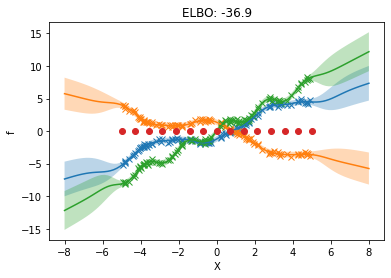

In [25]:
plot_model(m)

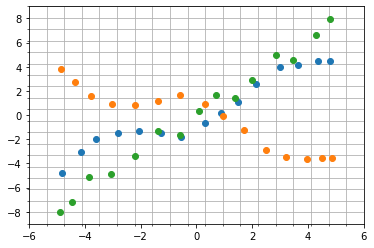

In [26]:
for i in range(len(m.inducing_variable.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variable.inducing_variable_list[i].Z)
    plt.plot(
        m.inducing_variable.inducing_variable_list[i].Z.numpy(),
        q_mu_unwhitened[:, i, None].numpy(),
        "o",
    )
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which="minor")

### Mixed kernel and uncorrelated inducing variables

In [27]:

# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(L)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [28]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, q_mu=q_mu, q_sqrt=q_sqrt
)

In [29]:
optimize_model_with_scipy(m)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44521D+03    |proj g|=  6.62929D+03

At iterate    1    f=  2.36416D+03    |proj g|=  1.23564D+03

At iterate    2    f=  1.83455D+03    |proj g|=  7.22082D+02

At iterate    3    f=  1.34617D+03    |proj g|=  4.07037D+02

At iterate    4    f=  9.75596D+02    |proj g|=  2.74850D+02

At iterate    5    f=  6.91998D+02    |proj g|=  4.13533D+02

At iterate    6    f=  5.67713D+02    |proj g|=  3.53914D+02

At iterate    7    f=  5.49446D+02    |proj g|=  1.18558D+02

At iterate    8    f=  5.42303D+02    |proj g|=  9.66796D+01

At iterate    9    f=  5.32036D+02    |proj g|=  4.68484D+01

At iterate   10    f=  5.15816D+02    |proj g|=  7.92374D+01

At iterate   11    f=  5.14297D+02    |proj g|=  3.02286D+02

At iterate   12    f=  4.64147D+02    |proj g|=  9.53409D+01

At iterate   13    f=  4.4

 This problem is unconstrained.



At iterate  146    f=  1.12384D+02    |proj g|=  1.44579D+02

At iterate  147    f=  1.09301D+02    |proj g|=  8.89163D+01

At iterate  148    f=  1.08054D+02    |proj g|=  4.39768D+01

At iterate  149    f=  1.07356D+02    |proj g|=  3.02128D+01

At iterate  150    f=  1.06397D+02    |proj g|=  3.08936D+01

At iterate  151    f=  1.03256D+02    |proj g|=  1.39941D+02

At iterate  152    f=  9.94933D+01    |proj g|=  7.08455D+01

At iterate  153    f=  9.70529D+01    |proj g|=  6.78200D+01

At iterate  154    f=  9.60498D+01    |proj g|=  1.05717D+02

At iterate  155    f=  9.52477D+01    |proj g|=  2.05553D+02

At iterate  156    f=  9.45967D+01    |proj g|=  2.63469D+01

At iterate  157    f=  9.41784D+01    |proj g|=  2.53075D+01

At iterate  158    f=  9.18455D+01    |proj g|=  1.20523D+02

At iterate  159    f=  8.99445D+01    |proj g|=  1.29951D+02

At iterate  160    f=  8.75443D+01    |proj g|=  1.19447D+02

At iterate  161    f=  8.50586D+01    |proj g|=  6.33255D+01

At iter

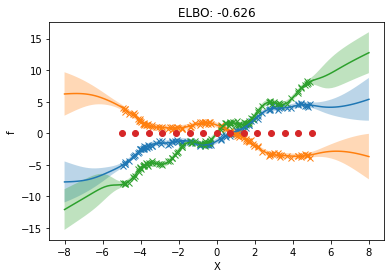

In [30]:
plot_model(m)